# GAN(Generative Adversarial Network)

 



## 1-1 GAN이란?

### 1-1-1 Vanilla GAN

In [1]:
import tensorflow as tf # 텐서플로우 2.x 실행

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tqdm.notebook import tqdm #진행도 확인하는 함수

학습이 된 Gan모델에 노이즈값을 넣은 뒤 예측한 이미지를 보여주는 함수입니다.

In [3]:
noise= np.random.normal(0, 1, [100, 100])
noise.shape

(100, 100)

In [4]:
def plot_generated_images(epoch, generator):
    noise= np.random.normal(0, 1, [100, 100]) #100개의 노이즈 값을 생성합니다.
    make_images = generator.predict(noise) # 노이즈값을 통해서 GAN으로 이미지 생성합니다.
    make_images = make_images.reshape(100, 28, 28) # Mnist 사이즈와 동일하게 바꿔줍니다.
    plt.figure(figsize=(10,10)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수 100만큼 반복
        plt.subplot(10, 10, i+1) #바둑판식으로 표현
        plt.imshow(make_images[i],plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [5]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001)

Vanilla GAN 모델링에 관한 코드입니다.  
GAN은 2개의 모델이 필수적으로 사용을 하게 됩니다.  

실제이미지와 가짜 이미지를 판별해주는 Discriminator  
가짜이미지를 생성하는 Generator 모델입니다.   
모델마다 각자의 optimizer를 갖고 있으며 --> 충돌을 방지를 합니다.

데이터는 Fashion Mnist데이터를 이용하여 실습하겠습니다.

Conv1D에서 Mnist 데이터를 학습을 시켰을 때는 /255를 통하여 0~1 사이의 실수를 만들었습니다.  

GAN에서는 -127.5를 뺀후 나누게 됩니다. 이러면 데이터가 -1 ~  1사이의 값이 됩니다.



In [7]:
epochs = 20  #반복 횟수를 정해줍니다.
batch_size = 128 #배치사이즈를 정해줍니다.

(x_train, _), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 
batch_count = x_train.shape[0] / batch_size  #데이터의 양을 배치사이즈 크기만큼 나눠서 학습시킵니다.

Generator 모델을 만듭니다.  
입력데이터는 100개의 노이즈 이며 3층으로 쌓은 FFN 입니다.  
활성함수는 ReLU를 사용하였고, 마지막에는 Tanh를 사용하였습니다.  
Tanh를 사용한 것은 데이터를 정규화 시킬 때 음수의 값을 포함하여 하였기 때문에  
생성된 값 또한 음수를 표현을 하기 위해서 Tanh를 사용하게 되었습니다. 

Binary_crossetropy를 사용하여 이진 분류를 사용하였고, optimizer는 adam을 사용하였습니다. 
  
속도를 높이기 위해 Dropout을 사용하게 되었습니다. 

Generator의 최종 결과는 784이고 이는 mnist의 이미지 크기와 동일합니다.


In [8]:
# Generator 
generator=models.Sequential()
generator.add(layers.Dense(256, input_dim=100, activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))


generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 559,632
Trainable params: 559,632
Non-trainable params: 0
_________________________________________________________________


discriminator 모델을 만듭니다. 
입력데이터는 minist파일의 크기이며 3층으로 쌓은 FFN 모델입니다.  
Generator와 다르게 unit의 수가 점점 줄어드는 것을 확인 할 수 있습니다.  

마지막 활성함수는 sigmoid를 사용함으로서 0 1사이에 거짓 이미지인지 실제 이미지인지를 판별을 해주는 것입니다.  

In [10]:
# Discriminator
discriminator=models.Sequential()
discriminator.add(layers.Dense(512,input_dim=784,activation='relu'))
discriminator.add(layers.Dense(256,activation='relu'))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


discriminator 학습 시킬 때는 참/거짓 데이터를 주고 가중치를 업데이트를 해야되지만, 이 discriminator가 gan 안에서 generator와 같이 학습할 때는 가중치가 고정되어 있어야 합니다. 그래서 gan 모델을 생성하기 전에 discriminator.trainable = False으로 설정합니다.      
-  compile() 함수가 호출될 때 trainable 속성이 모델에 적용
- https://keras.io/getting_started/faq/#how-can-i-freeze-keras-layers

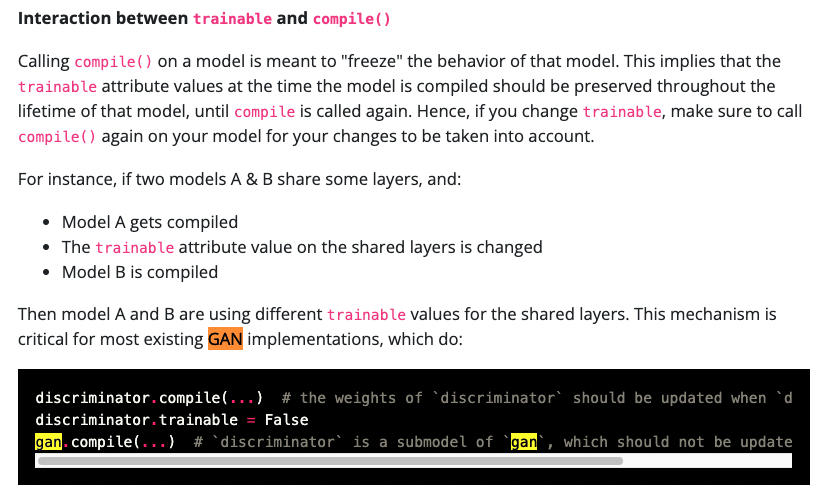

#### GAN

In [12]:
# GAN - G + D 

discriminator.trainable=False # weight 학습불가

gan_input = layers.Input(shape=(100,))
x = generator(gan_input)
gan_output= discriminator(x)


gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

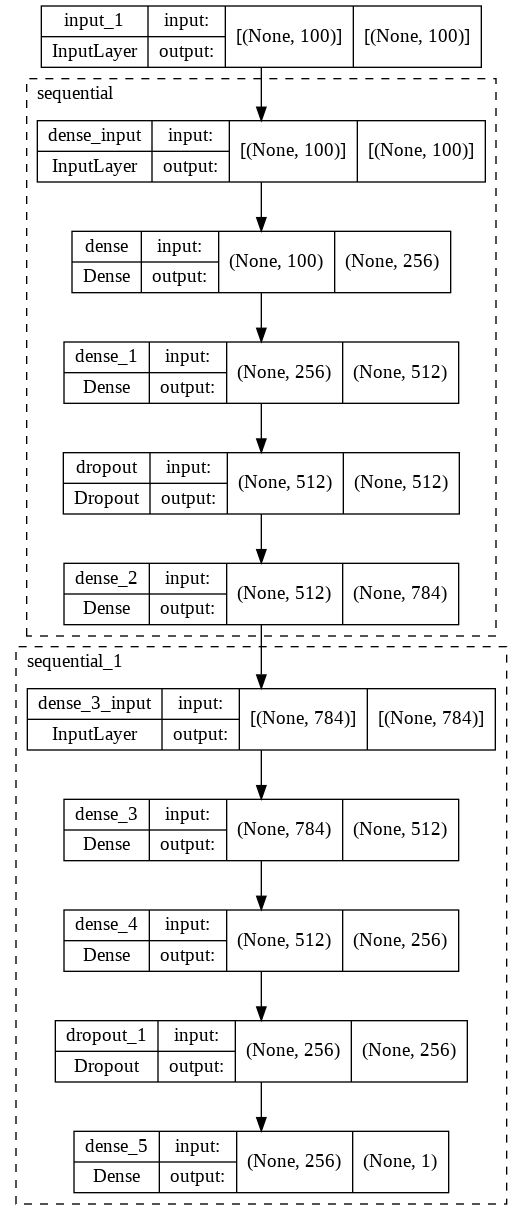

In [13]:
tf.keras.utils.plot_model(gan, expand_nested=True, show_shapes = True)



실제이미지와 가짜이미지를 판결하기 위해서 Binary_CrossEntropy를 사용하였고,  
input의 데이터는 가짜이미지이고, output은 실제인지 가짜인지 판별해주는 discriminator의 결과값입니다.  

#### 모델학습

모델을 학습시키는 코드입니다. 

위에서 설정한 Epochs 수만큼 학습을 하게 되고, batch_count만큼 반복하게 됩니다.     
x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]의 코드는 
데이터의 0 ~ 데이터의 크기 중 batch_size만큼 랜덤으로 뽑는 것입니다.(Noise)

진짜 이미지와 가짜 이미지를 합친 후 그 크기만큼의 배열을 생성한 뒤 실제 이미지에는 0.9의 값을 주고 가짜 이미지에는 0의 값을 줍니다.  

그 후 discriminator를 학습을 시킵니다.    


배치사이즈 크기만큼 배열을 생성한 뒤 값을 1로 세팅하여 gan에 노이즈값과 함께 학습을 시킵니다. 

In [14]:
import numpy as np
np.random.randint(0, x_train.shape[0], [128, 100]).shape

(128, 100)

Epochs :  1


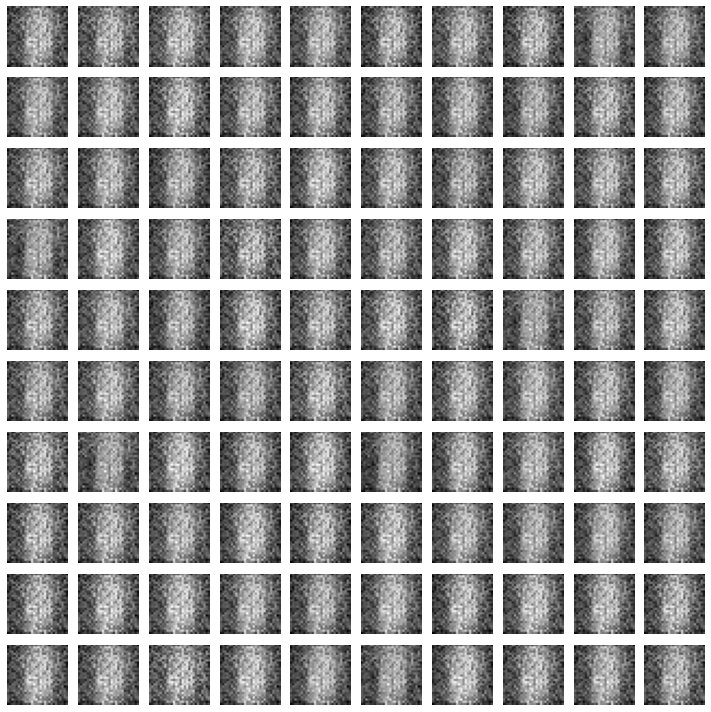

Epochs :  2
Epochs :  3
Epochs :  4
Epochs :  5


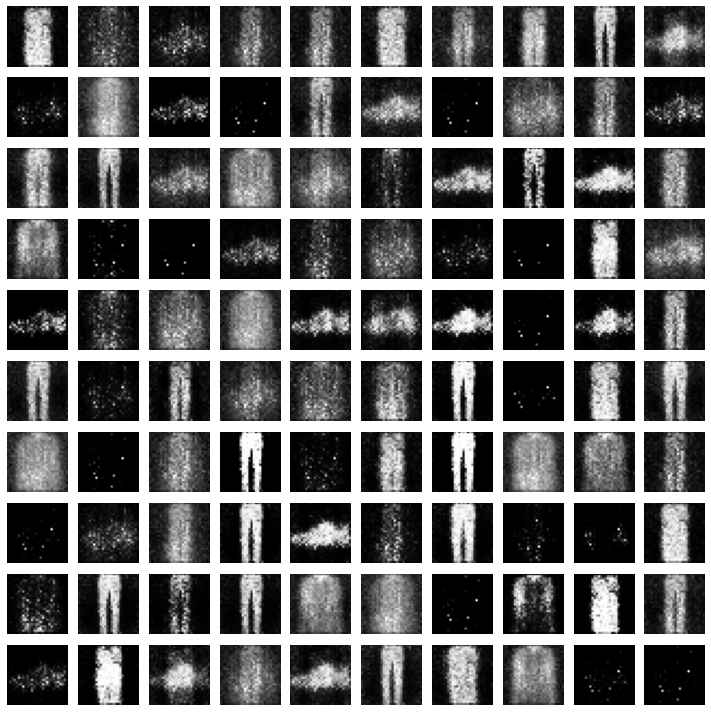

Epochs :  6
Epochs :  7
Epochs :  8
Epochs :  9
Epochs :  10


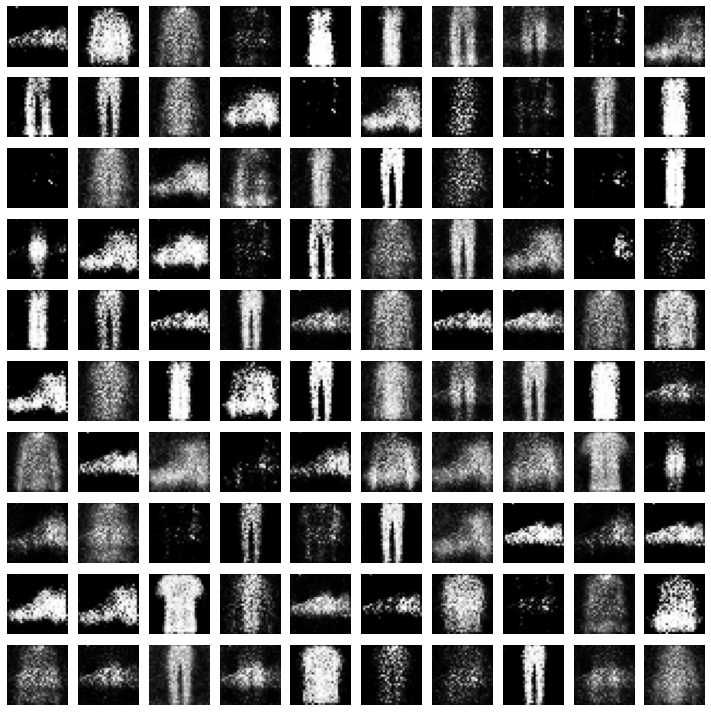

Epochs :  11


KeyboardInterrupt: ignored

In [15]:
for Epochs in range(1,epochs+1):
    print("Epochs : ",Epochs)
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) #노이즈값 생성
        generated_images = generator.predict(noise) #노이즈 값으로 이미지 예측
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        

        X= np.concatenate([image_batch, generated_images])
        y_dis=np.zeros(2*batch_size) # 초기값을 0으로 주고 (batch_size*2 데이터)
        
        y_dis[:batch_size] = 0.9 # 라벨 스무딩
        y_dis[batch_size+1:] = 0.1 # 라벨 스무딩

        #training
        discriminator.train_on_batch(X, y_dis)
        
        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen)

    if Epochs == 1 or Epochs % 5 == 0: #5번 마다 이미지 출력
        plot_generated_images(Epochs, generator)
        

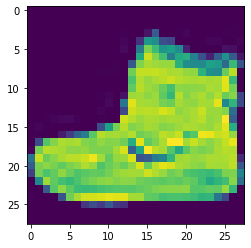

In [ ]:
(x_sample, _), (_, _) = datasets.fashion_mnist.load_data() 
plt.imshow(x_sample[0])

### 1-1-2 DCGAN

이번에는 GAN의 응용모델인 DCGAN을 설명하겠습니다.  
DCGAN은 "Deep Convolutional Generative Adversarial Nets"의 약자이며 FFN 부분을 CNN으로 바꾼 부분입니다.  
DCGAN이 탄생하게 된 것은 기존에 있던 GAN이 불안정하며 새로 만들어진 결과물들이 좋은지를 판단하기가 어렵게 되어 나오게 된 것입니다.
기존에 있던 CNN과 다른 점은 Pooling layer를 사용하지 않고 이를 strides로 교체를 한 것입니다.

Vanilla GAN을 했을 당시에는 -1 ~ 1 사이의 값으로 하였으나  
DCGAN에서는 결과가 좋지 않아 0 ~ 1 사이의 값으로 정규화를 진행하였습니다.

In [16]:
import tensorflow as tf

In [17]:
# 함수 선언 & 데이터 설정
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,datasets
import numpy as np
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data() 

x_train = x_train.reshape((-1,28, 28, 1))
x_train = x_train / 255.0  

iterations = 2000 #반복횟수
batch_size = 100

Generator를 선언하는 부분입니다.  
해당 코드에서 중요한 것은 Strides 부분입니다.  


Conv2DTranspose라는 Deconvolution라고 불리우고 이미지 해상도를 올리 때 사용합니다.  
Conv2D와 사용법은 동일하고 Conv2D를 거꾸로 해놓은 버전이라고 생각하시면 됩니다.
  


처음 FFN으로 통하여 이미지의 크기를 지정해줍니다.  
그 후 리사이즈를 통해 이미지가 Conv2D에 학습 할 수 있도록 바꿔줍니다. 



Conv2DTranspose에서 필터사이즈 256, 커널사이즈 4, strides 2, padding은 same으로 설정 하였습니다.  
다층 Conv2D를 지나고 Dense로 가게 되면 28  28  1 이미지의 형태가 됩니다.

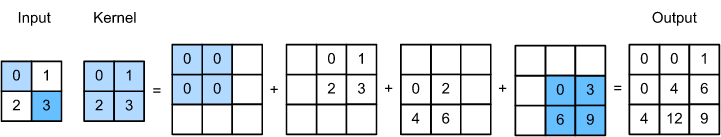

In [18]:
generator= models.Sequential()
# generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,), activation=tf.nn.leaky_relu))
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.ReLU())
generator.add(layers.Reshape((14, 14, 128)))

generator.add(layers.Conv2D(256, 5, padding='same')) #첫 번째 Conv2D
generator.add(layers.ReLU())

generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same')) #Deconvolution
generator.add(layers.ReLU())

generator.add(layers.Conv2D(256, 5, padding='same')) #두 번째 Conv2D
generator.add(layers.ReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) #세 번째 Conv2D
generator.add(layers.ReLU())
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) #mnist 이미지 크기로 변환

Summary를 살펴 보게 되면  
첫 Conv2D를 지나게 되면 14 * 14 * 256의 이미지 형태가 됩니다.  
Conv2DTranspose 부분에서 지나게 되면서 28 * 28 * 256 형태로 바뀌게 됩니다.  
이는 strides부분이 기존에 있던 크기를 확장시키게 됩니다. 
strides가 3이면 이미지는 42 * 42 * 256 형태가 되는 것입니다.  
padding을 설정하게 됨으로써 strides 부분만 영향을 주게 되는 것입니다. 

위에 코드에서 strides와 padding을 조정하고 summary를 출력을 해보면 이해하기 쉬울 것입니다.

In [19]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25088)             2533888   
                                                                 
 re_lu (ReLU)                (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 256)       819456    
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 256)      1048832   
 nspose)                                                         
                                                      

Discriminator는 FFN 부분이 Conv2D로 바뀐 말고는 달라진 점은 없습니다. 

Conv2D 코드를 보면 strides 부분이 추가가 되어있으며 Polling 부분이 없는 것이 확인 됩니다.  

Adam이 아닌 RMSprop으로 진행하였습니다.  

In [20]:
# Activation: 

discriminator = models.Sequential()
discriminator.add(layers.Conv2D(128, 3,input_shape=[28,28,1]))
discriminator.add(layers.LeakyReLU())
# discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
# discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Flatten())
# discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Summary를 살펴보면 Padding이 설정되지 않기 대문에 커널 사이즈의 영향을 받아 이미지 크기가 줄어 들었습니다.  
또한 strides 부분이 2로 설정 되어있있기에 이미지의 2번 째 Conv2D 부터는 이미지 크기가 줄어드는 게 보입니다.

In [21]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 26, 26, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 128)        

2개의 모델을 선언하고 complile을 하고 있습니다.

In [22]:
discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [23]:
for Epochs in range(iterations):
    if (Epochs+1) % 100 == 0 : print("Epoach : ",Epochs+1)
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images = generator.predict(noise)

    real_images = x_train[np.random.randint(0,x_train.shape[0],batch_size)]
    images = np.concatenate([generated_images, real_images])
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9 
    
    # D 학습
    discriminator.train_on_batch(images, y_dis)

    random_latent_vectors = np.random.normal(size=(batch_size, 100))
    y_gen = np.zeros((batch_size, 1))

    gan.train_on_batch(random_latent_vectors, y_gen)

    if Epochs % 100 == 0:
        generated_images = generated_images.reshape(100,28,28)
        plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
          
          plt.subplot(10, 10, i+1)
          plt.imshow(generated_images[i], interpolation='nearest')
          plt.axis('off')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# DCGAN's PAPER
# https://arxiv.org/pdf/1511.06434.pdf

### 1-1-3 GAN 문제 1

In [ ]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) 

epochs = 20 
batch_size = 128 

(x_train, y_train), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 
batch_count = x_train.shape[0] / batch_size 

generator=models.Sequential()
generator.add(layers.Dense(256,input_dim=100,activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator=models.Sequential()

#### 문제 1 ####
discriminator.add() # mnist와 가짜 이미지 생성하는 판별자의 FFN
discriminator.add() # 한층을 더 쌓는 FFN
discriminator.add() #드랍아웃 설정
################

discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator.trainable=False 
gan_input = layers.Input(shape=(100,))

#### 문제 2 ####
x = generator() # generator의 input 
gan_output= discriminator() # discriminator의 input
################

gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

for Epochs in range(1,epochs+1):
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) 
        generated_images = generator.predict(noise) 
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        X= np.concatenate([image_batch, generated_images]) 

        #### 문제 3 ####
        y_dis # discriminator 학습을 위한 y 값 생성
        y_dis # 라벨스무딩
        ################

        discriminator.train_on_batch(X, y_dis)
        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen)
    
    if Epochs == 1 or Epochs % 20 == 0: 
        make_images = generated_images.reshape(100,28,28) 
        plt.figure(figsize=(10,10))
        for i in range(make_images.shape[0]): 
          plt.subplot(10, 10, i+1)
          plt.imshow(make_images[i], interpolation='nearest')
          plt.axis('off')
        

### 1-1-4 GAN 문제 2

In [ ]:
(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data() 

x_train = x_train.reshape((-1,28, 28, 1))
x_train = x_train / 255.0  

iterations = 2000 
batch_size = 100

generator=models.Sequential()
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.LeakyReLU())
generator.add(layers.Reshape((14, 14, 128)))
generator.add(layers.Conv2D(256, 5, padding='same'))
generator.add(layers.LeakyReLU())

#### 문제 1 ####
generator.add() #이미지 업스케일링 하기
################

generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) 
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same'))
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) 



discriminator=models.Sequential()
discriminator.add(layers.Conv2D(128, 3,input_shape=[28,28,1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())

#### 문제 2 ####
discriminator.add() # 3차원 -> 2차원 축소
discriminator.add() # 드랍아웃 
discriminator.add() # unit 1인 FFN
################

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004,clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


for Epochs in range(iterations):
    if (Epochs+1) % 100 == 0 : print("Epoach : ",Epochs+1)
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images = generator.predict(noise)

    real_images = x_train[np.random.randint(0,x_train.shape[0],batch_size)]
    images = np.concatenate([generated_images, real_images])
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9 
    
    #### 문제 3 ####
    discriminator # discriminator 학습
    ################

    random_latent_vectors = np.random.normal(size=(batch_size, 100))

    y_gen = np.zeros((batch_size, 1))

    #### 문제 4 ####
    gan #generator 학습
    ################

    if Epochs % 100 == 0:
        generated_images = generated_images.reshape(100,28,28)
        plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
          
          plt.subplot(10, 10, i+1)
          plt.imshow(generated_images[i], interpolation='nearest')
          plt.axis('off')
